In [1]:
#imports
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import losses, optimizers, models, layers, Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

In [2]:
#get image data
os.makedirs('body_score_dataset', exist_ok=True)
!git clone -b body_scores_prediction_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./body_score_dataset 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into './body_score_dataset'...
remote: Enumerating objects: 15246, done.
remote: Counting objects: 100% (3683/3683), done.
remote: Compressing objects: 100% (3664/3664), done.
remote: Total 15246 (delta 20), reused 3677 (delta 17), pack-reused 11563 (from 1)
Receiving objects: 100% (15246/15246), 1.30 GiB | 50.38 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (10878/10878), done.


In [3]:
#load label data
df_train_data = pd.read_csv('/kaggle/working/body_score_dataset/train_data.csv')
df_train_data.head()

,filename,bodyScore
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0


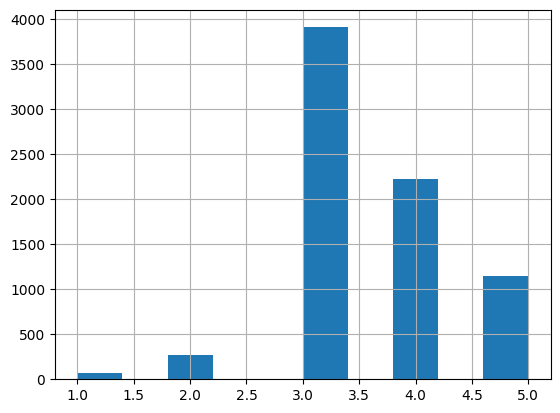

In [4]:
df_train_data['bodyScore'].hist()
plt.show()

In [5]:
#get file path for image files
df_train_data['filepath'] = df_train_data.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)

In [6]:
df_train_data.head()

,filename,bodyScore,filepath
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0,body_score_dataset/0003/6c11338b-ce1a-4e23-b50...
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0,body_score_dataset/0002/53c3ffb8-ccef-41bf-ae8...
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0,body_score_dataset/0005/c13a8227-7747-4eac-990...
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0,body_score_dataset/0004/90bb5ad3-c9bd-4cb7-a95...
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0,body_score_dataset/0001/224ef780-210b-4b9e-a4d...


In [7]:
#create array of body scores and file paths
body_scores = df_train_data.bodyScore.values
file_paths = df_train_data.filepath.values

In [8]:
#load image and body_score
#apply preprocessing to image
#return image and body_score
def load_and_preprocess_image(file_path, body_score=None):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    
    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    image = tf.cast(image, tf.float32) / 255.0 
    if body_score is not None:
        return image, body_score
    else:
        return image

In [9]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((file_paths, body_scores))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

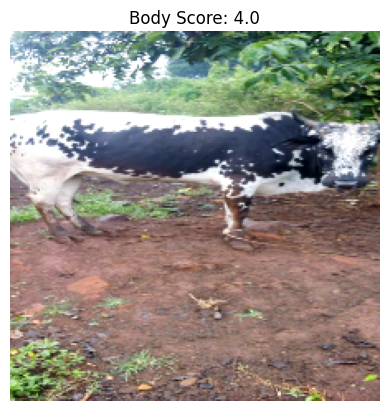

In [10]:
#view contents of dataset
for item in dataset.take(1):
    plt.title(f'Body Score: {item[1].numpy()}')
    plt.imshow(item[0].numpy())
    plt.axis('off')

In [11]:
#shuffle and batch data
dataset = dataset.shuffle(buffer_size=2000)
dataset = dataset.batch(batch_size=32)

In [12]:
#split data into train and val sets
dataset_length = 0
for _ in dataset:
    dataset_length+=1
print(dataset_length)
train_size = int(dataset_length*0.7)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

238


In [13]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [15]:
# Create the new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1)
])


In [16]:
initial_learning_rate = 1e-3

In [17]:
# Compile the model
optimizer = optimizers.AdamW(learning_rate=initial_learning_rate, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss=losses.mae)

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [19]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


I0000 00:00:1724576293.045783      81 service.cc:145] XLA service 0x7bbaec024090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724576293.045856      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724576293.045863      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724576346.012105      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 136s 262ms/step - loss: 7.7230 - val_loss: 29.2458 - learning_rate: 0.0010
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - loss: 1.6042 - val_loss: 0.9438 - learning_rate: 0.0010
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - loss: 0.9313 - val_loss: 0.8408 - learning_rate: 0.0010
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - loss: 0.7916 - val_loss: 0.7445 - learning_rate: 0.0010
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - loss: 0.7197 - val_loss: 0.6749 - learning_rate: 0.0010
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 199ms/step - loss: 0.6796 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - loss: 0.5967 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - loss: 0.5610 - val_loss: 0.5025 - learning_rate: 0.0010
Epoch 9/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - loss: 0.5151 - val_loss: 0.4848 - learni

In [26]:
#load submission file
df_submit = pd.read_csv('/kaggle/working/body_score_dataset/sample_submission.csv')
df_submit.head()

,filename,bodyScore
0,b909623b-39b0-47e7-ba71-356d74d3f2cb5779846075...,0
1,8dc92b10-e198-4bad-a413-2cea6ef30e8c3040278561...,0
2,605f77a6-58e2-4d53-9821-cc9f760617f89211689386...,0
3,716bdb88-5a6f-4a9f-89fa-6c51b3a4a2a62638764935...,0
4,e92d6398-ab98-44fd-869e-7a3fac84f2976528877008...,0


In [27]:
#prepare test dataset
df_submit['filepath'] = df_submit.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)
df_submit_file_paths = df_submit.filepath.values
test_dataset = tf.data.Dataset.from_tensor_slices((df_submit_file_paths))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [28]:
#make predictions
predictions = model.predict(test_dataset)
predictions_flattened = predictions.flatten()
df_submit['bodyScore'] = [5.0 if i>5 else i for i in predictions_flattened]
df_submit[['filename', 'bodyScore']].to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step
